# Lab Three: Clustering

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

Our data set consists of over 5 million rows of flight information in the domestic United States for the year of 2015. In order to optimize our modeling time, we have narrowed the scope of our classification tasks to the Dallas area only (Dallas Love Field and DFW airports). 

## Rubric

### [Business Understanding](#Business-Understanding) (10 points total)

- [10 points] Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

### [Data Understanding](#Data-Understanding) (20 points total)

#### [Data Understanding 1](#Data-Understanding-1)

- [10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

#### [Data Understanding 2](#Data-Understanding-2)

- [10 points] Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

### [Modeling and Evaluation](#Modeling-and-Evaluation) (50 points total)

Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.

#### Option A: Cluster Analysis

- Perform cluster analysis using several clustering methods
- How did you determine a suitable number of clusters for each method?
- Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).
- Describe your results. What findings are the most interesting and why?

#### [Modeling and Evaluation 1](#Modeling-and-Evaluation-1)

- Train and adjust parameters

#### [Modeling and Evaluation 2](#Modeling-and-Evaluation-2)

- Evaluate and compare

#### [Modeling and Evaluation 3](#Modeling-and-Evaluation-3)

- Visualize results

#### [Modeling and Evaluation 4](#Modeling-and-Evaluation-4)

- Summarise the ramifications

### [Deployment](#Deployment) (10 points total)

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
- How would your deploy your model for interested parties?
- What other data should be collected?
- How often would the model need to be updated, etc.?

### [Exceptional Work](#Exceptional-Work) (10 points total)

You have free reign to provide additional analyses or combine analyses.

# Business Understanding
Jump to [top](#Rubric)

# Data Understanding
Jump to [top](#Rubric)

## Data Understanding 1
Jump to [top](#Rubric)

> Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

The initial data pre-processing has already been covered in Labs 1, 2, and the Mini-Lab. Here we have collapsed our code as much as possible.

##### Libraries

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

# Machine learning
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE 

## [Jump to Clean Data](#Final-Data-Set)

Clicking this link will skip over the cleanup work and let you get started with the final data set. 

##### Load Data

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Due to the way these columns are formatted, we want to keep the leading zeros during our import. 
# Later on will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
airlines = pd.read_csv('../Data/airlines.csv')
airports = pd.read_csv('../Data/airports.csv')
flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
# airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
# airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
# flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

# Subset to DFW Area
df = df[(df.ORIGIN_AIRPORT == 'DFW') | (df.ORIGIN_AIRPORT == 'DAL')]

##### Process Flight Dates

In [3]:
# Create flight date
df['FLIGHT_DATE'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df.YEAR, df.MONTH, df.DAY)])

# Combine date & time for departure and arrival
# Source: https://stackoverflow.com/questions/17978092/combine-date-and-time-columns-using-python-pandas
df['SCHEDULED_DEPARTURE_DT'] = pd.to_datetime(df['FLIGHT_DATE'].astype(str) + ' ' + df['SCHEDULED_DEPARTURE'].astype(str))
df['SCHEDULED_ARRIVAL_DT']   = pd.to_datetime(df['FLIGHT_DATE'].astype(str) + ' ' + df['SCHEDULED_ARRIVAL'].astype(str))

##### Append Dallas-Area Weather

In [4]:
# Read in the data
weather = pd.read_csv('../Data/dfw_weather.csv')
weather['dt_iso'] = weather['dt_iso'].astype(str)

# Remove "+0000 UTC"
weather['dt_iso_update'] = weather['dt_iso'].str.split('+').str[0]

# Convert new column to a datetime type
weather['date_time'] =  pd.to_datetime(weather['dt_iso_update'], format='%Y-%m-%d %H:%M')

weather['date_time'] = weather['date_time'].dt.round('30min')  
df['SCHEDULED_DEPARTURE_DT'] = df['SCHEDULED_DEPARTURE_DT'].dt.round('30min')

df = pd.merge(df, weather, left_on='SCHEDULED_DEPARTURE_DT', right_on='date_time')

# Remove unnecessary columns from weather data
col_to_drop = ['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'feels_like', 'temp_min', 'temp_max',
              'sea_level', 'grnd_level', 'dt_iso_update', 'weather_icon', 'weather_description', 'date_time']
df = df.drop(columns = col_to_drop)

##### Format Columns Consistenty

In [5]:
# Convert to snake case
df.columns = df.columns.str.lower()

##### Deal with Missing Values

In [6]:
# Fill missing values with 0
cols = ['air_system_delay',
        'security_delay',
        'airline_delay',
        'late_aircraft_delay',
        'weather_delay', 
        'rain_1h', 
        'rain_3h', 
        'snow_1h', 
        'snow_3h']

df[cols] = df[cols].fillna(0)

In [7]:
# Remove cancelled flights
df = df[df.cancelled == 0]

In [8]:
# Drop cancelled & cancellation_reason
df = df.drop(['cancelled', 'cancellation_reason'], axis = 1)

In [9]:
# Drop remaining rows that contain missing values
df = df.dropna()

##### One-Hot Encoding

In [11]:
# Columns to one-hot encode
categorical_columns = ['airline_code',
                       'weather_main',
                       'origin_airport']

for column in categorical_columns:
  tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns, drop_first = True)
  df_ohe = pd.merge(
      left = df,
      right = tempdf,
      left_index = True,
      right_index = True
  )
  df_ohe = df_ohe.drop(columns = categorical_columns)

In [12]:
list(df_ohe.columns)

['year',
 'month',
 'day',
 'day_of_week',
 'flight_number',
 'tail_number',
 'destination_airport',
 'scheduled_departure',
 'departure_time',
 'departure_delay',
 'taxi_out',
 'wheels_off',
 'scheduled_time',
 'elapsed_time',
 'air_time',
 'distance',
 'wheels_on',
 'taxi_in',
 'scheduled_arrival',
 'arrival_time',
 'arrival_delay',
 'diverted',
 'air_system_delay',
 'security_delay',
 'airline_delay',
 'late_aircraft_delay',
 'weather_delay',
 'airline',
 'flight_date',
 'scheduled_departure_dt',
 'scheduled_arrival_dt',
 'temp',
 'pressure',
 'humidity',
 'wind_speed',
 'wind_deg',
 'rain_1h',
 'rain_3h',
 'snow_1h',
 'snow_3h',
 'clouds_all',
 'weather_id',
 'airline_code_AS',
 'airline_code_B6',
 'airline_code_DL',
 'airline_code_EV',
 'airline_code_F9',
 'airline_code_MQ',
 'airline_code_NK',
 'airline_code_OO',
 'airline_code_UA',
 'airline_code_US',
 'airline_code_VX',
 'airline_code_WN',
 'weather_main_Clouds',
 'weather_main_Drizzle',
 'weather_main_Dust',
 'weather_main_Fog

In [13]:
pd.set_option('display.max_columns', None)
df_ohe.head()

,year,month,day,day_of_week,flight_number,tail_number,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,airline,flight_date,scheduled_departure_dt,scheduled_arrival_dt,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,airline_code_AS,airline_code_B6,airline_code_DL,airline_code_EV,airline_code_F9,airline_code_MQ,airline_code_NK,airline_code_OO,airline_code_UA,airline_code_US,airline_code_VX,airline_code_WN,weather_main_Clouds,weather_main_Drizzle,weather_main_Dust,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Snow,weather_main_Thunderstorm,origin_airport_DFW
0,2015,1,1,4,1057,N3ASAA,MIA,0515,0703,108.0,15.0,0718,161,155.0,133.0,1121,1031,7.0,0856,1038,102.0,0,0.0,0.0,0.0,0.0,102.0,American Airlines Inc.,2015-01-01,2015-01-01 05:00:00,2015-01-01 08:56:00,35.11,1031,66,4.7,20,0.0,0.0,0.0,0.0,90,804,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,2015,1,1,4,1890,N377DA,ATL,0545,0603,18.0,13.0,0616,124,104.0,86.0,731,0842,5.0,0849,0847,-2.0,0,0.0,0.0,0.0,0.0,0.0,Delta Air Lines Inc.,2015-01-01,2015-01-01 06:00:00,2015-01-01 08:49:00,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,2015,1,1,4,72,N5EKAA,MCO,0600,0606,6.0,18.0,0624,145,142.0,120.0,985,0924,4.0,0925,0928,3.0,0,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,2015-01-01,2015-01-01 06:00:00,2015-01-01 09:25:00,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,2015,1,1,4,1100,N3GWAA,LGA,0600,0554,-6.0,33.0,0627,190,191.0,154.0,1389,1001,4.0,1010,1005,-5.0,0,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,2015-01-01,2015-01-01 06:00:00,2015-01-01 10:10:00,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
5,2015,1,1,4,925,N634NK,OAK,0600,0600,0.0,13.0,0613,238,209.0,188.0,1457,0721,8.0,0758,0729,-29.0,0,0.0,0.0,0.0,0.0,0.0,Spirit Air Lines,2015-01-01,2015-01-01 06:00:00,2015-01-01 07:58:00,34.61,1030,63,4.7,20,0.5,0.0,0.0,0.0,90,500,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [14]:
# Drop tail_number, destination_airport & airline
df_ohe = df_ohe.drop(['tail_number', 
                      'destination_airport', 
                      'airline'], axis = 1)

In [15]:
# Convert times to integers
df_ohe['scheduled_departure'] = df_ohe['scheduled_departure'].astype(int)
df_ohe['departure_time'] = df_ohe['departure_time'].astype(int)
df_ohe['wheels_off'] = df_ohe['wheels_off'].astype(int)
df_ohe['scheduled_time'] = df_ohe['scheduled_time'].astype(int)
df_ohe['wheels_on'] = df_ohe['wheels_on'].astype(int)
df_ohe['scheduled_arrival'] = df_ohe['scheduled_arrival'].astype(int)
df_ohe['arrival_time'] = df_ohe['arrival_time'].astype(int)

##### Flight Delay Response Variable

In [16]:
# Add response variable bucket for delay time for departure
# 0 is Early (negative time)
# 1 is On_Time or between 0 and 10 minutes late
# 2 is Late (between 11 and 30 min late)
# 3 is very late (between 31 and 60 min late)
# 4 is extremely late (over 61 min late)

delay_labels = ['0', '1', '2', '3', '4']
delay_bins   = [-np.inf, -1, 10, 30, 60, np.inf]

df_ohe['delay_bucket'] = pd.cut(df_ohe['departure_delay'],
                                bins = delay_bins,
                                labels = delay_labels)

# Check counts by bucket
df_ohe['delay_bucket'].value_counts()

# Convert from category to int
df_ohe['delay_bucket'] = df_ohe['delay_bucket'].astype(int)

## Data Understanding 2
Jump to [top](#Rubric)

> Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

### Final Data Set

The delay data set contains basic flight information from our original data plus weather data for the appropriate date & time of each flight, encoded variables for `DESTINATION_AIRPORT` and `TAIL_NUMBER`, and one-hot encoded airline codes.
Newly created variables included buckets for the flight’s scheduled departure and arrival times (morning, afternoon, and evening), distance (medium and long), and a response variable `DELAY_BUCKET` that groups delay times by length of delay in minutes.
- **Early** is defined as 0 and is any value where the `DEPARTURE_DELAY` is < 0.
- **On-Time** is defined as 1 and is any value where 0 <= `DEPARTURE_DELAY` <= 10
- **Late** is defined as 2 and is any value where 11 <= `DEPARTURE_DELAY` <= 30
- **Very Late** is defined as 3 and is any value where 31 <= `DEPARTURE_DELAY` <= 60
- **Extremely Late** is defined as 4 and is any value where `DEPARTURE_DELAY` >= 61

In [17]:
# Save data
# df_delay.to_csv('../Data/df_delay.csv', index=False)

In [18]:
# Load data from here to save time
# df_delay = pd.read_csv('../Data/df_delay.csv')

# Modeling and Evaluation
Jump to [top](#Rubric)

## Modeling and Evaluation 1

> Train and adjust parameters

### Best Performing Classifier Model from Lab 2

In Lab 2, we determined that running KNN on the oversampled data using SMOTE with Grid Search was our best performing model. We've included it here as a baseline for our clustering models.

In [19]:
# # Create X and y for delay data set
# if 'delay_bucket' in df_ohe:
#     y_del = df_ohe['delay_bucket'].values
#     X_del = df_ohe.iloc[:,:-1].values

In [20]:
# # Oversample using SMOTE
# oversample = SMOTE()
# X_del_smote, y_del_smote = oversample.fit_resample(X_del, y_del)

In [21]:
# from sklearn.model_selection import StratifiedShuffleSplit

# sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

# for train_index, test_index in sss.split(X_del_smote, y_del_smote):
#     X_train_del_smote, X_test_del_smote = X_del_smote[train_index], X_del_smote[test_index]
#     y_train_del_smote, y_test_del_smote = y_del_smote[train_index], y_del_smote[test_index]

# print("Split on Oversampled Data:\n")
# print('Training Features Shape:', X_train_del_smote.shape)
# print('Training Labels Shape:', y_train_del_smote.shape)
# print('Testing Features Shape:', X_test_del_smote.shape)
# print('Testing Labels Shape:', y_test_del_smote.shape)

In [22]:
# %%time
# # https://realpython.com/knn-python/
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV

# # Create KNN Classifier
# parameters = {
#      "n_neighbors": list(range(1,20,2)),
#      "weights": ["uniform", "distance"],
#  }
# gridsearch = GridSearchCV(KNeighborsClassifier(), 
#                           parameters, 
#                           cv = 10, 
#                           scoring = 'f1_weighted',
#                           n_jobs = -1)

# gridsearch.fit(X_train_del_smote, y_train_del_smote)
# gridsearch.best_params_

In [23]:
# test_preds_grid2 = gridsearch.predict(X_test_del_smote)

In [24]:
# from sklearn import metrics
# print("Accuracy:",metrics.accuracy_score(y_test_del_smote, test_preds_grid2))
# print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del_smote, test_preds_grid2, average = 'weighted')))
# print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del_smote, test_preds_grid2, average = 'weighted')))
# print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del_smote, test_preds_grid2, average = 'weighted')))

In [25]:
# # Save and run model with K=1 and pull metrics
# knn_delay = KNeighborsClassifier(n_neighbors = 1, weights = 'uniform')
# knn_delay.fit(X_train_del_smote, y_train_del_smote)
# y_pred_knn_del = knn_delay.predict(X_test_del_smote)

## Modeling and Evaluation 2
Jump to [top](#Rubric)

> Evaluate and compare

## Modeling and Evaluation 3
Jump to [top](#Rubric)

> Visualize results

## Modeling and Evaluation 4
Jump to [top](#Rubric)

> Summarise the ramifications

# Deployment
Jump to [top](#Rubric)

# Exceptional Work
Jump to [top](#Rubric)

# Matt
Jump to [top](#Rubric)

### Data

In [26]:
# Drop datetime columns
df_ohe = df_ohe.drop(['flight_date', 
                      'scheduled_departure_dt', 
                      'scheduled_arrival_dt'], 
                     axis = 1)

# Create X and y for delay data set
if 'delay_bucket' in df_ohe:
    y_del = df_ohe['delay_bucket'].values
    X_del = df_ohe.iloc[:,:-1].values

### Model

In [28]:
# Source: https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0
# Standardize the features
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create the object
scaler = StandardScaler()

# Calculate the mean and standard deviation
scaler.fit(df_ohe)
df_ohe_pca_scaled = scaler.transform(df_ohe)

# Calculate the PCA that explains 95% of the variance
pca_95 = PCA(n_components=0.95, random_state=2015)
pca_95.fit(df_ohe_pca_scaled)
df_pca_95 = pca_95.transform(df_ohe_pca_scaled)

# Display the PCA values
np.cumsum(pca_95.explained_variance_ratio_*100)

array([10.00169571, 17.84870052, 25.09016297, 29.93878603, 34.08712899,
       37.59359618, 40.35889675, 42.85410659, 45.22909059, 47.49823296,
       49.72437622, 51.7808123 , 53.76477536, 55.72495139, 57.65723399,
       59.51295233, 61.35558868, 63.17372814, 64.97827534, 66.77044153,
       68.55280935, 70.32577545, 72.08864172, 73.8488969 , 75.59828071,
       77.34434391, 79.06036251, 80.73184594, 82.38772496, 83.96749911,
       85.49564726, 86.97002722, 88.42871007, 89.78489899, 91.11507231,
       92.33699192, 93.44965399, 94.48116692, 95.44015684])

Text(0, 0.5, 'Explained Variance')

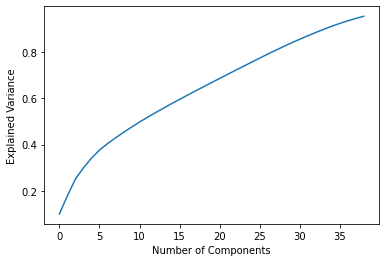

In [29]:
# Plot PCA results
plt.plot(np.cumsum(pca_95.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

In [ ]:
# Run PCA for feature reduction
from sklearn.decomposition import PCA

X_del_pca = PCA(n_components = 2).fit_transform(X_del)
plt.scatter(X_del_pca[:,0], 
            X_del_pca[:,1])

In [ ]:
from sklearn.cluster import AgglomerativeClustering
classifier = AgglomerativeClustering(n_clusters = 5,
                                     linkage = "ward",
                                     affinity = "euclidean")
model = classifier.fit(df_pca_95)

In [ ]:
# Visualize the results of the clustering algorithm
plt.scatter(X[clusters == 0, 0], X[clusters == 0, 1], label = 'Delay = 0')
plt.scatter(X[clusters == 1, 0], X[clusters == 1, 1], label = 'Delay = 1')
plt.scatter(X[clusters == 2, 0], X[clusters == 2, 1], label = 'Delay = 2')
plt.scatter(X[clusters == 3, 0], X[clusters == 3, 1], label = 'Delay = 3')
plt.scatter(X[clusters == 4, 0], X[clusters == 4, 1], label = 'Delay = 4')
plt.title('Clusters')
plt.show()

In [ ]:
# Compare results to the actual target values
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], label = 'Type 1')
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], label = 'Type 2')
plt.scatter(X[Y == 2, 0], X[Y == 2, 1], label = 'Type 3')

In [ ]:
# Distances between clusters
distances = model.distances_

print("Number of Clusters: ", model.n_clusters_)
print("Minimum Distance Between Clusters: ", distances.min())
print("Maximum Distance Between Clusters: ", distances.max())

In [ ]:
# Create dendrogram
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

Z = hierarchy.linkage(model.children_, 'ward')

plt.figure(figsize=(20,10))
dn = hierarchy.dendrogram(Z)